In [1]:
import os
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import tensorflow as tf
import torch
import pandas as pd
import csv
from glob import glob
from sklearn.metrics import f1_score

In [5]:
id2label = {
    0: 'Idle',
    1: 'Toric Marking',
    2: 'Implant Ejection',
    3: 'Incision',
    4: 'Viscodilatation',
    5: 'Capsulorhexis',
    6: 'Hydrodissetion',
    7: 'Nucleus Breaking',
    8: 'Phacoemulsification',
    9: 'Vitrectomy',
    10: 'Irrigation/Aspiration',
    11: 'Preparing Implant',
    12: 'Manual Aspiration',
    13: 'Implantation',
    14: 'Positioning',
    15: 'OVD Aspiration',
    16: 'Suturing',
    17: 'Sealing Control',
    18: 'Wound Hydratation',
}

label2id = {v: k for k, v in id2label.items()}

## 推論結果の可視化

In [492]:
predict_csv = '/data1/github/MICCAI2020/cataractsWorkflow/result/cnn_only/tf-xception-skipframe=1/predict/train/23/train23.csv'
target_csv = '/data1/github/MICCAI2020/cataractsWorkflow/data/train/23/train23.csv'

In [37]:
df_pr = pd.read_csv(predict_csv)
df_gt = pd.read_csv(target_csv)

In [49]:
df_pr

,Frame,Steps
0,1,11
1,2,11
2,3,11
3,4,11
4,5,11
...,...,...
11177,11178,0
11178,11179,0
11179,11180,0
11180,11181,0


In [297]:
map_ = np.eye(19)[df_gt['Steps']]

In [301]:
map_[::1].shape

(11182, 19)

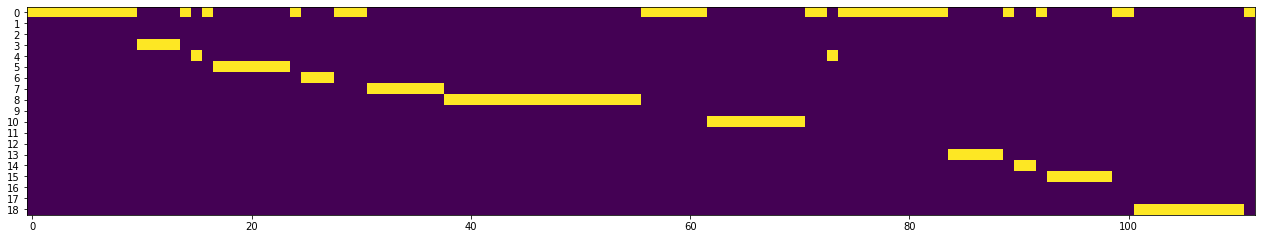

In [136]:
plt.figure(figsize=(22, 14))
plt.yticks(np.arange(0, 19, 1))
plt.imshow(np.eye(19)[df_gt['Steps']].T[:, ::100])

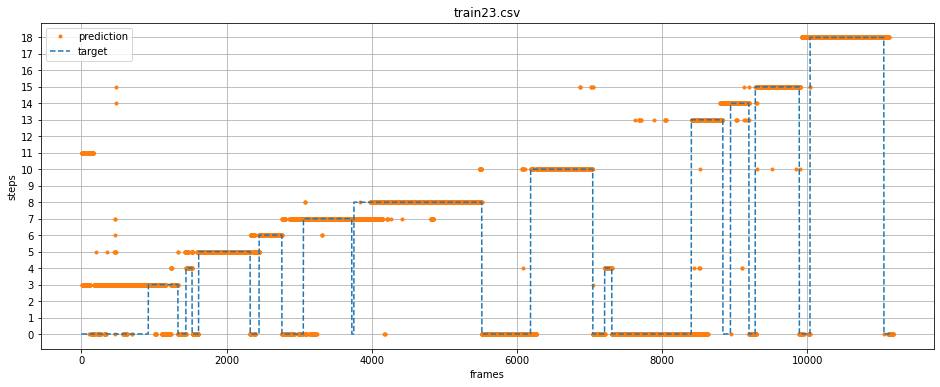

In [475]:
# build instance
plt.figure(figsize=(16, 6))
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))  # 縦軸目盛を整数に

# plot
plt.plot(df_pr['Frame'], df_pr['Steps'], '.', label='prediction', color='tab:orange')
plt.plot(df_gt['Frame'], df_gt['Steps'], label='target', color='tab:blue', linestyle='dashed')

plt.title(os.path.basename(target_csv))
plt.xlabel('frames')
plt.ylabel('steps')
plt.yticks(np.arange(0, 19, 1))  # 縦軸目盛を明示的につける
plt.grid()
plt.legend()

plt.show()

---
# Scratch


In [485]:
import os
import numpy as np
import pandas as pd
import gym


class ProcedureMaze(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, csv_file, skip_frame=1):
        """`action_space`, `observation_space`, `reward_range` are necessary
        Observation:
        Type: Box(2)
        Num     Observation     Min                  Max
        0       frame_id          1      number of frame           
        1       task              0                   18
        Actions:
        Type: Discrete(19)
        Num   Action
        0     Idle
        1~18  task   
        """
        super().__init__()
        # 予測結果から迷路を生成
        self.maze = self._generate_maze(csv_file, skip_frame)  # (0, 0)からスタート

        self.action_space = gym.spaces.Discrete(19)  # classes: 18 + 1
        self.observation_space = gym.spaces.Box(
            low=np.array([1, 0], dtype=np.float32),
            high=np.array([self.maze.shape[0], 19], dtype=np.float32),
            shape=(2, )
        )  # [frame, task]
        self.reward_range = [-1., 100.]
        # 環境を初期化
        self.reset()

    def reset(self):
        """necessary method
        """
        self.steps = 0
        self.pos = [1, 0]  # はじめはframe_id=1,task=0から始まる
        self.done = False
        return self._observe()

    def step(self, action):
        """necessary method
        actionを行った処理（1回ごと）
        return: observation(state), reward, done(episode終了判定), info(追加の情報の辞書)
        """
        self.pos = [self.pos[0] + 1, action]
        
        next_pos = self._observe()
        reward = self._get_reward(next_pos)
        self.done = self._is_done(next_pos)
        
        return next_pos, reward, self.done, {}

    def _get_reward(self, pos):
        """報酬を計算
        TODO:報酬をいくつに設定するか？
        ゴールだけが正しいことに意味はないので、ゴールの報酬は特に設定しない
        """        
        current_task = np.argmax(self.maze[pos[0] - 1])        
        if pos[1] == current_task == 0:
            # 予測のtaskと同じ(Idle)だと少ない報酬を与える
            return 1
        elif pos[1] == current_task:
            # 予測のtaskと同じ(Idle以外)だと大きな報酬を与える
            return 10
        else:
            # 予測のtaskと異なるとペナルティを与える
            return -1

    def _is_done(self, pos):
        """終了判定
        x軸方向に進めなくなったらTrueを返す
        """
        return self.maze.shape[0] == pos[0]

    def _observe(self):
        """次のstateを返す
        移動先の座標を観測とする
        """
        # x座標は常に進める
        # actionがそのままy座標となる
        return self.pos

    def _generate_maze(self, csv_file, skip_frame=1):
        df = pd.read_csv(csv_file)
        onehot = np.eye(19)[df["Steps"]]  # 19 classes
        return onehot[::skip_frame]

    def render(self, mode='human', close=False):
        """necessary method
        """
        if mode == 'rgb_array':
            output = self.maze.copy()
            output[self.pos[0] - 1, self.pos[1]] = 2  # 現在地を2とする
            return output

        elif mode == 'human':
            target = self.maze.copy()
            target = np.argmax(target, axis=-1)  # cast to class_id from onehot
            # [class_id(pred), class_id(target)]
            output = [self.pos[1], target[self.pos[0] - 1]]
            return output


In [489]:
env = ProcedureMaze('/data1/github/MICCAI2020/cataractsWorkflow/data/train/01/train01.csv', skip_frame=1)
env.maze.shape

(14380, 19)

In [490]:
frames = []
total_reward = 0
for episode in range(1):
    state = env.reset()
    frames.append(env.render(mode='human'))
#     print(state)
    done = False
    steps = 0
    while not done:
        action = 18
        state, reward, done, _ = env.step(action)
        total_reward += reward
        frames.append(env.render(mode='human'))
#         print(state, reward)
        steps += 1
        
#         if steps > 100:
#             break
env.close()
print(total_reward)

9007


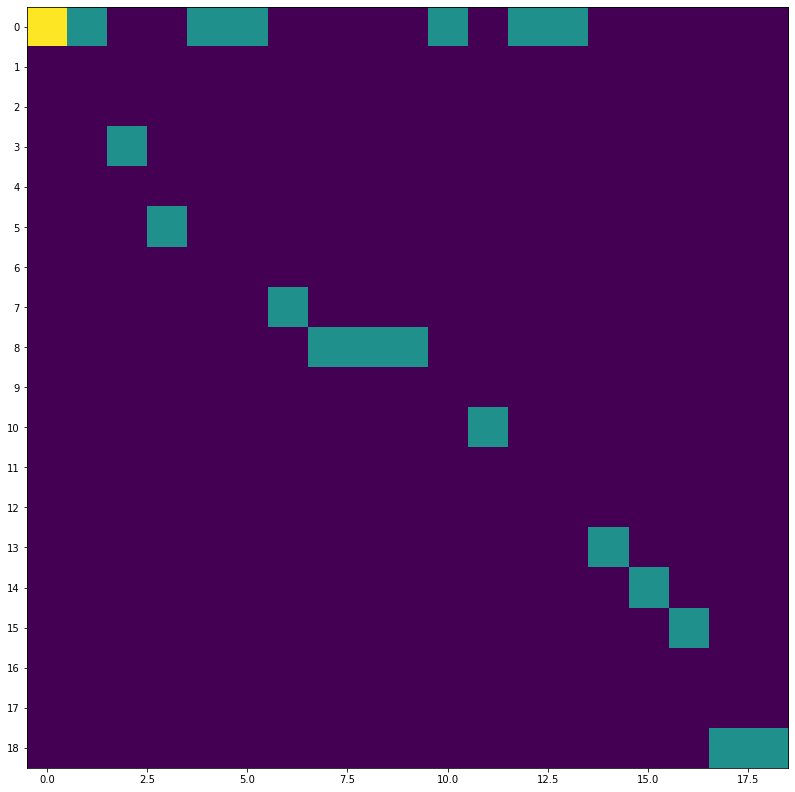

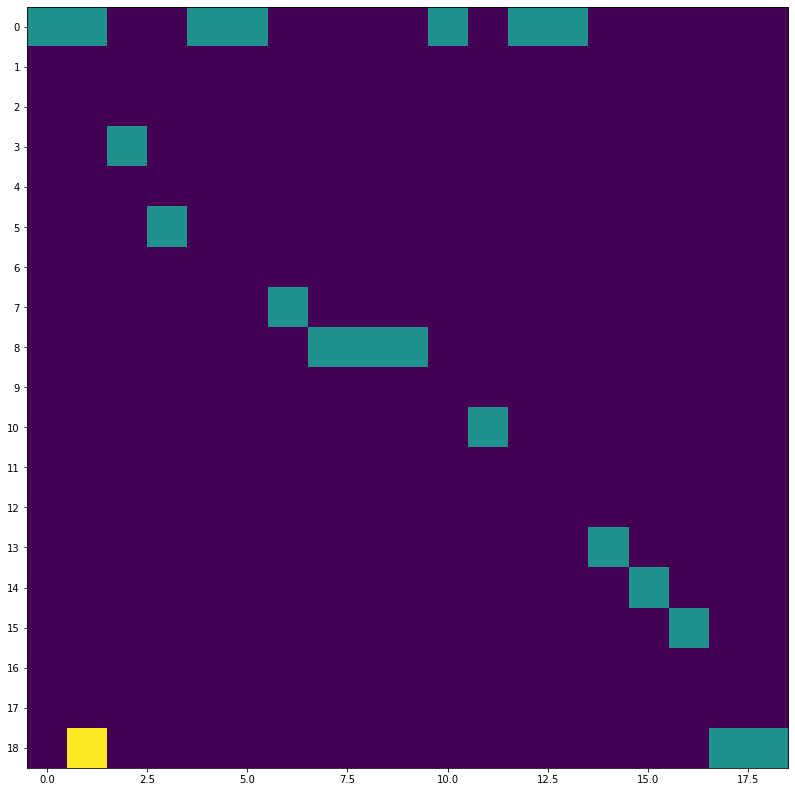

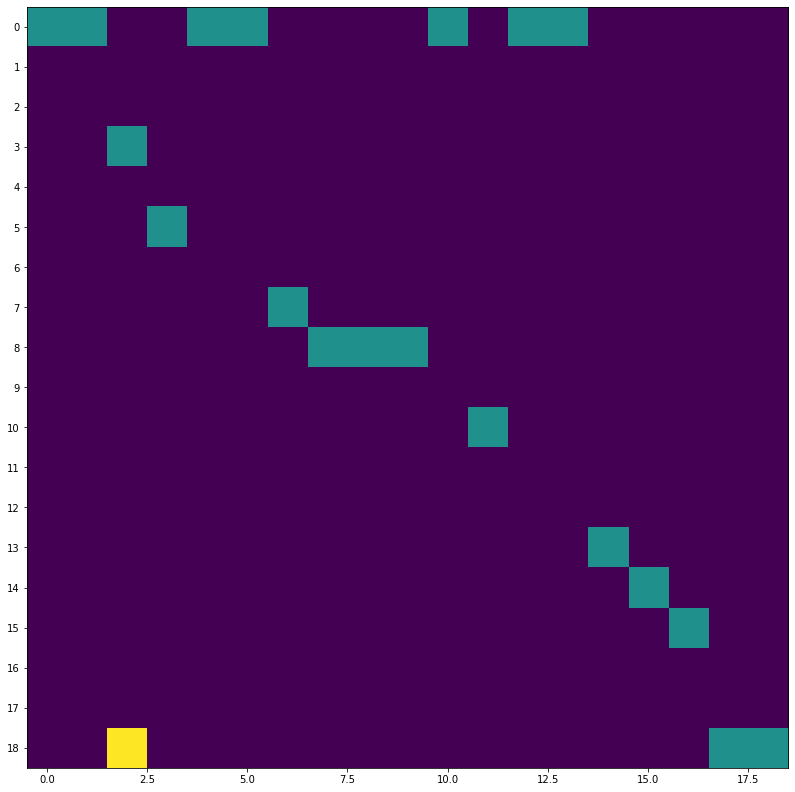

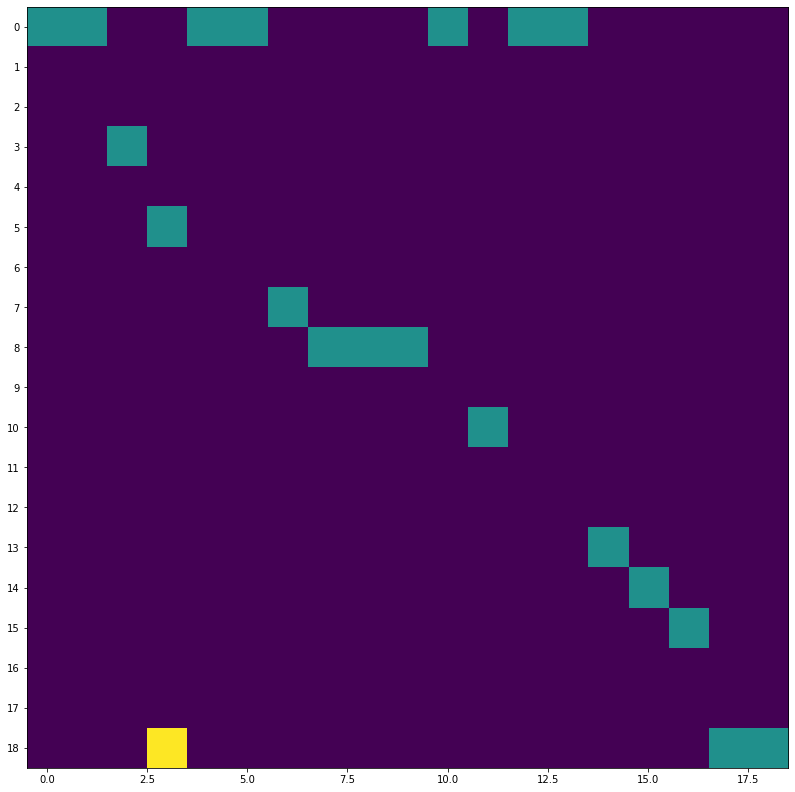

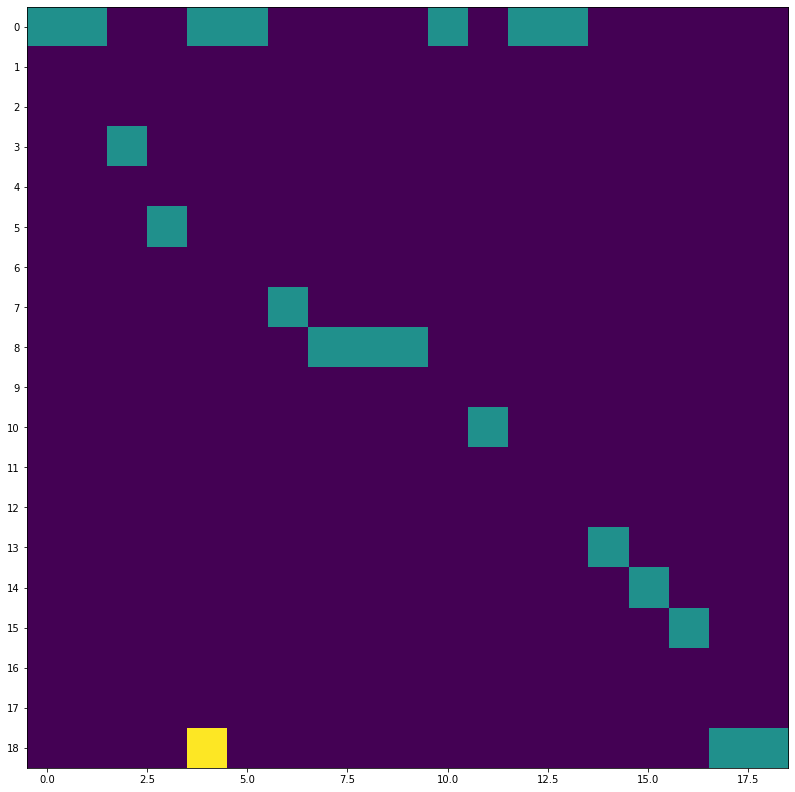

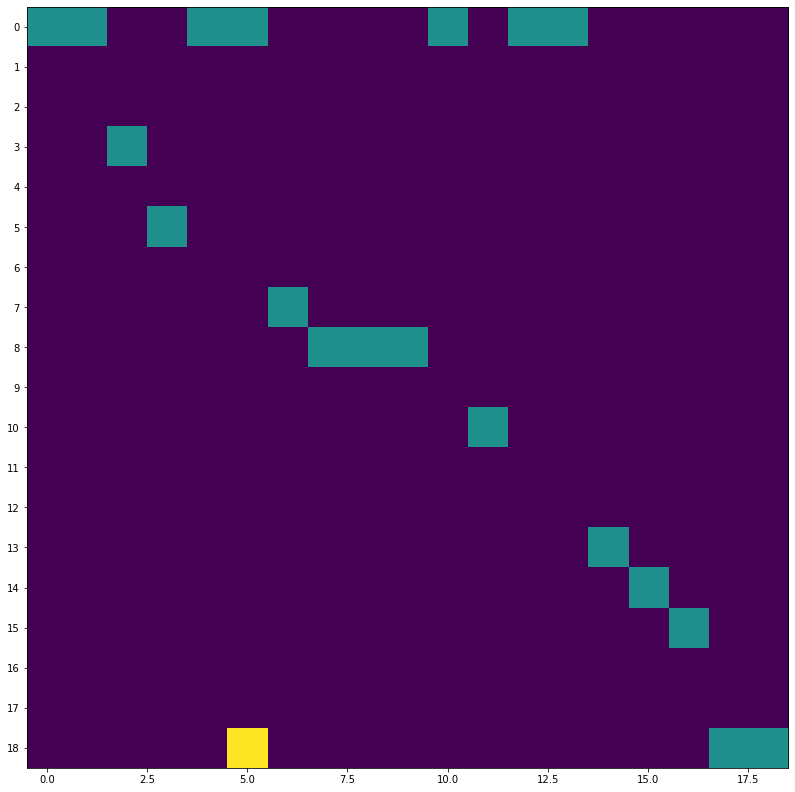

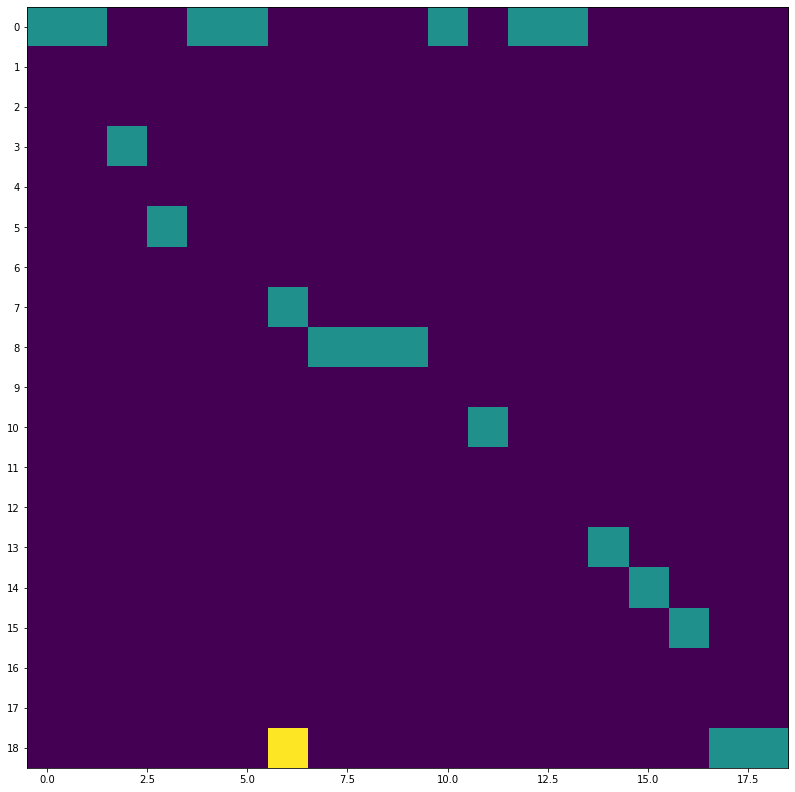

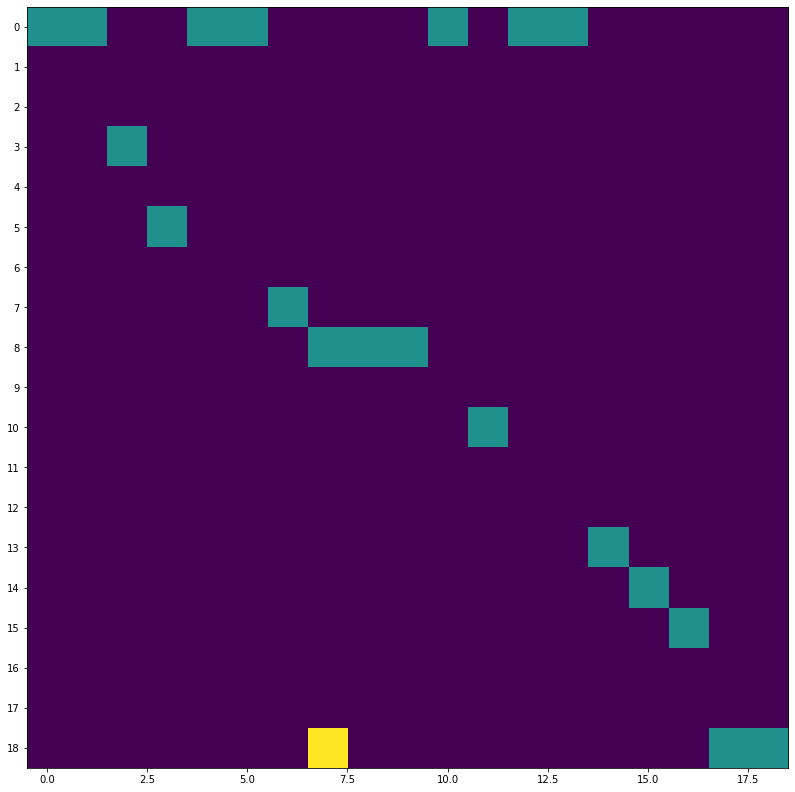

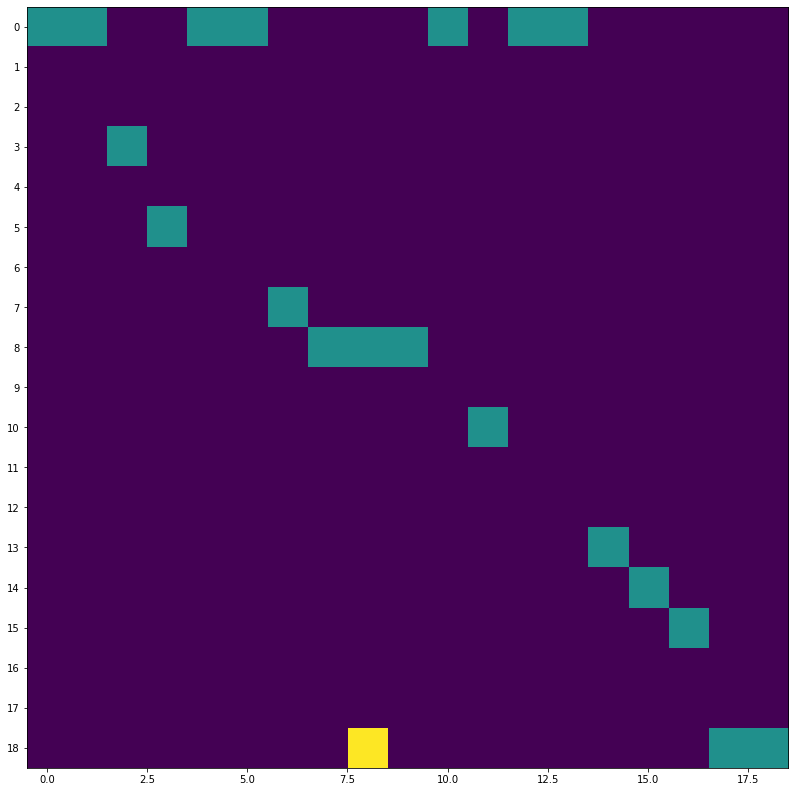

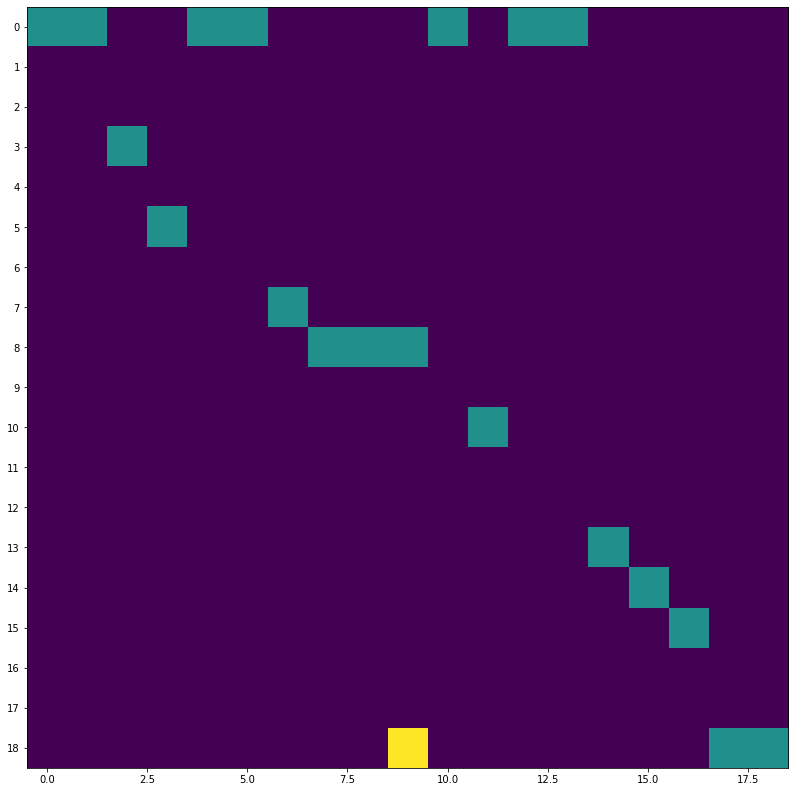

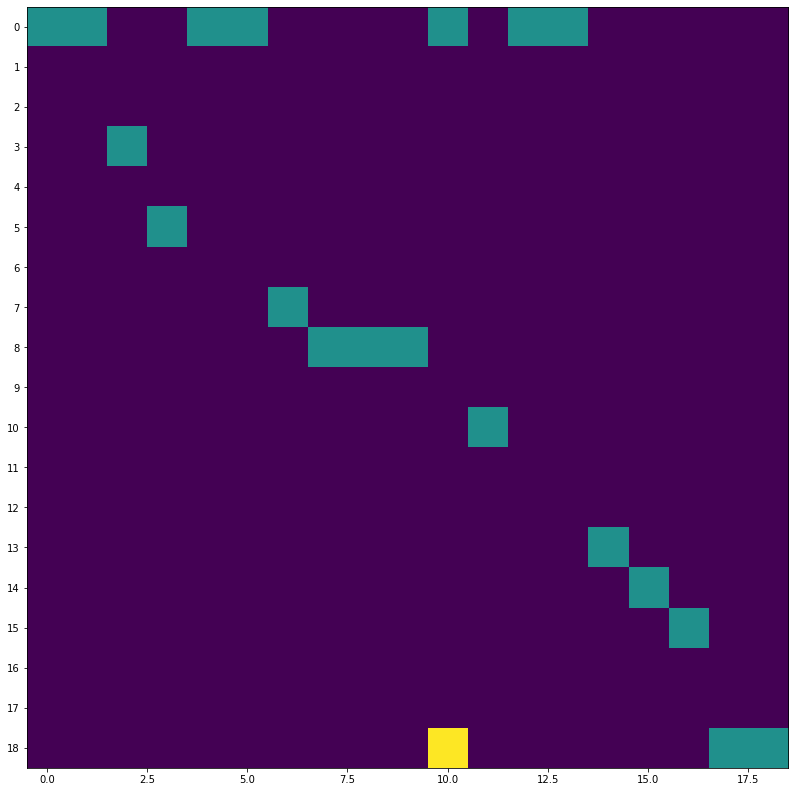

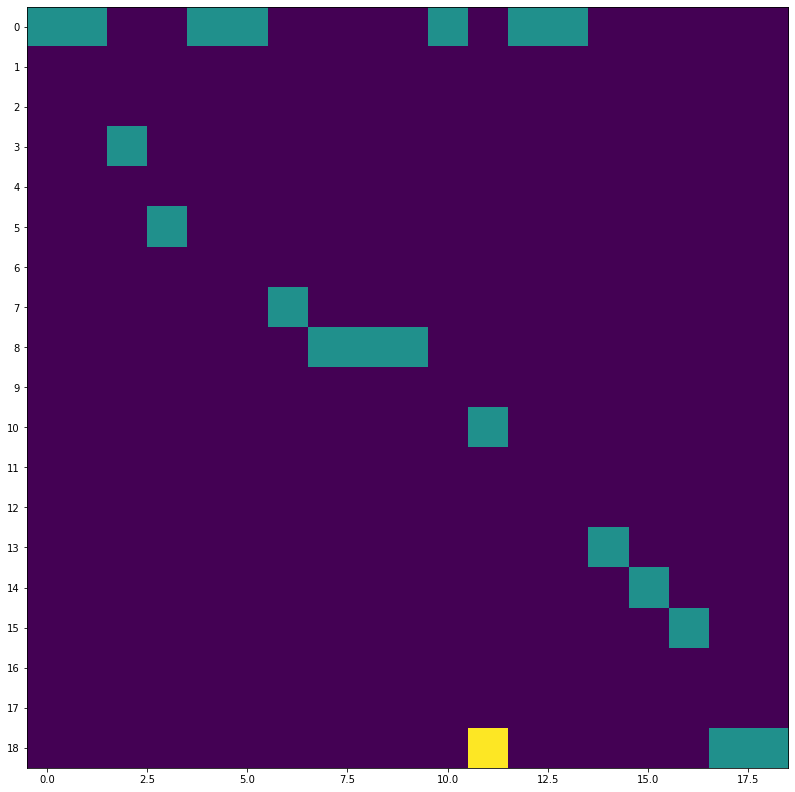

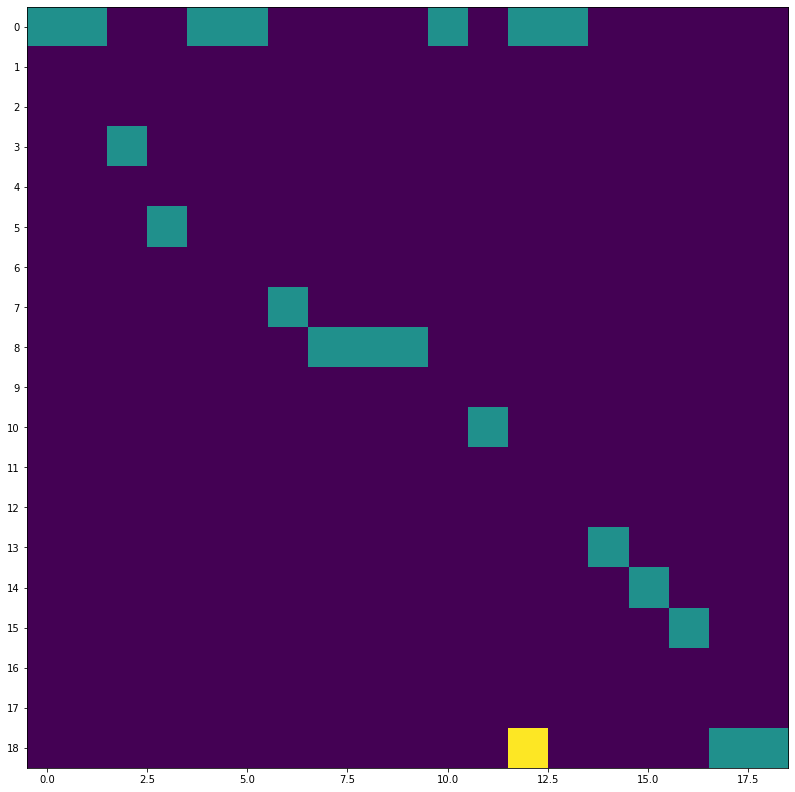

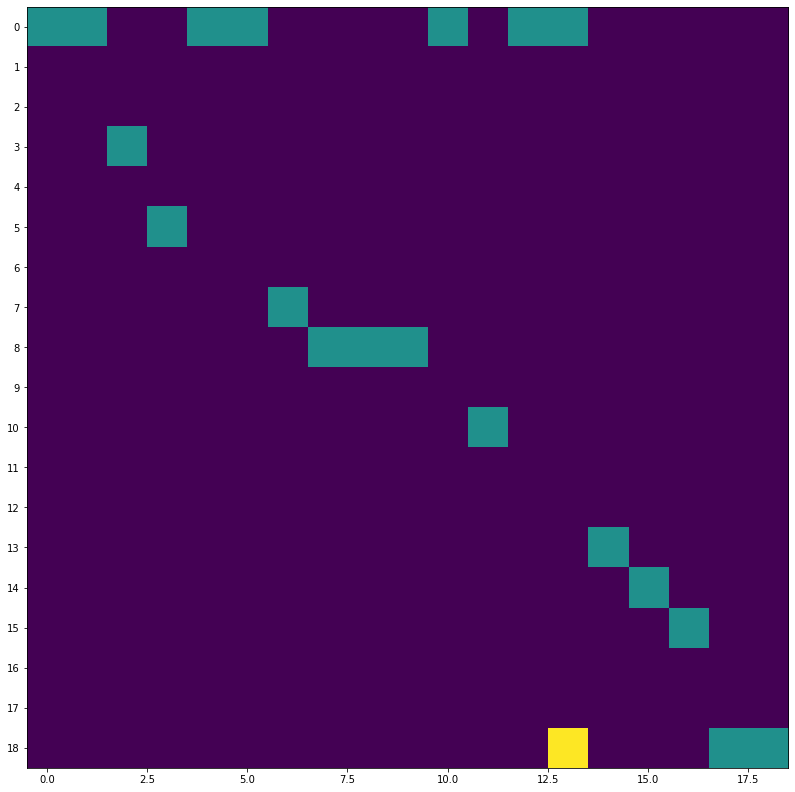

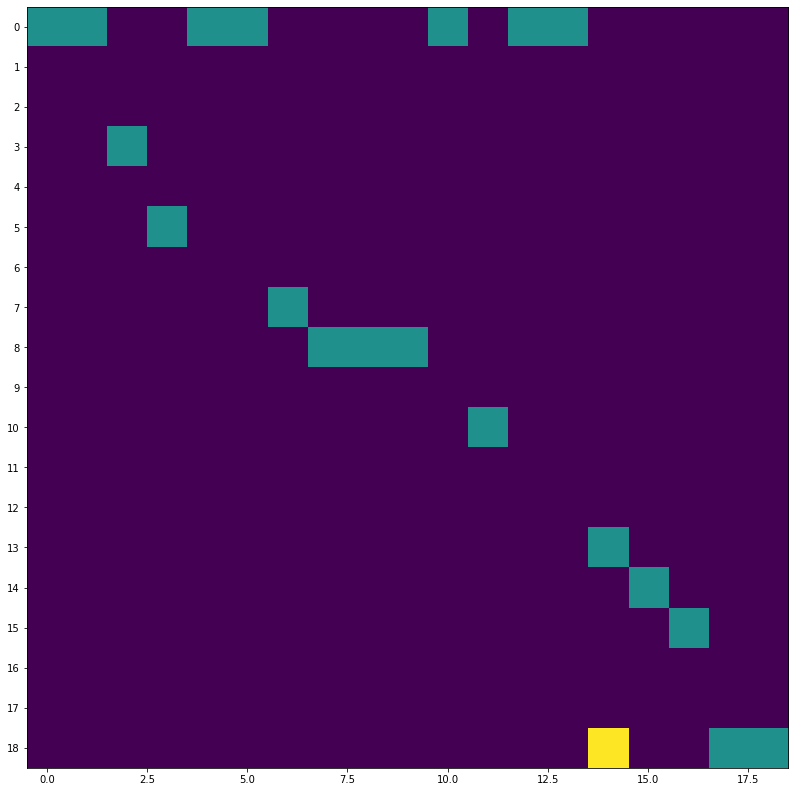

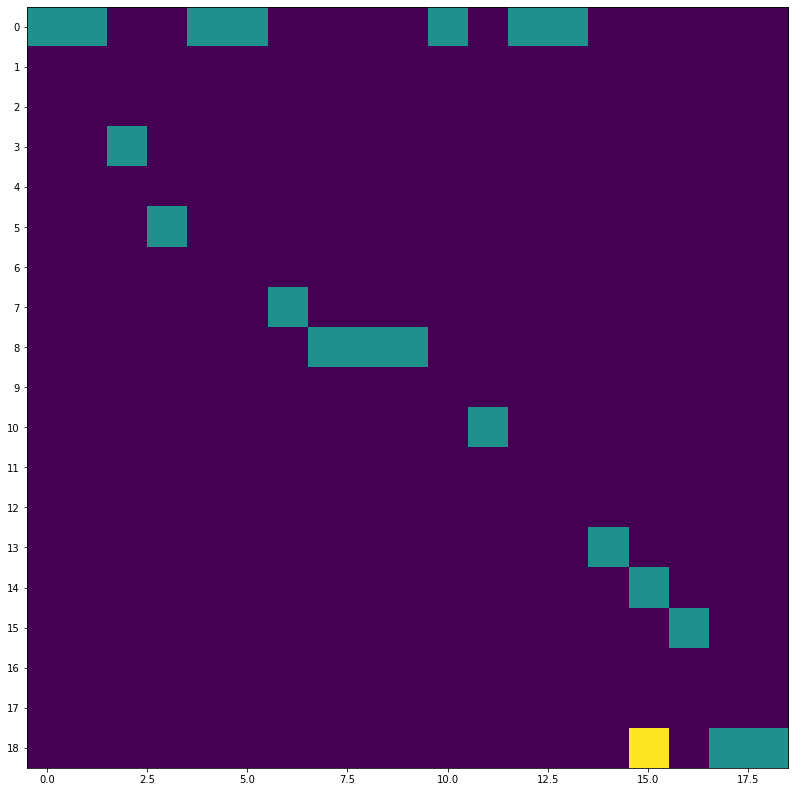

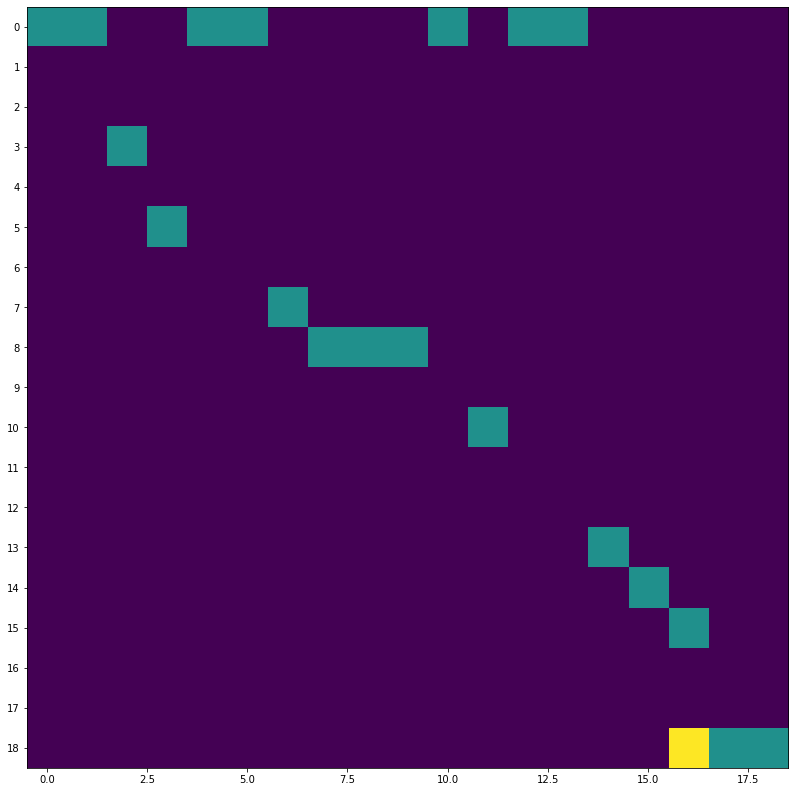

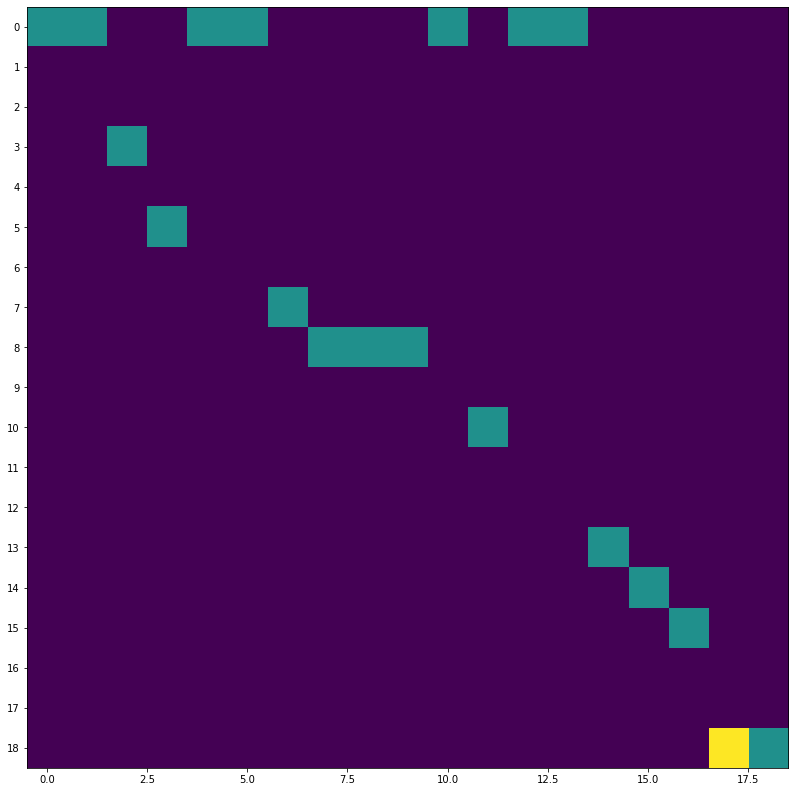

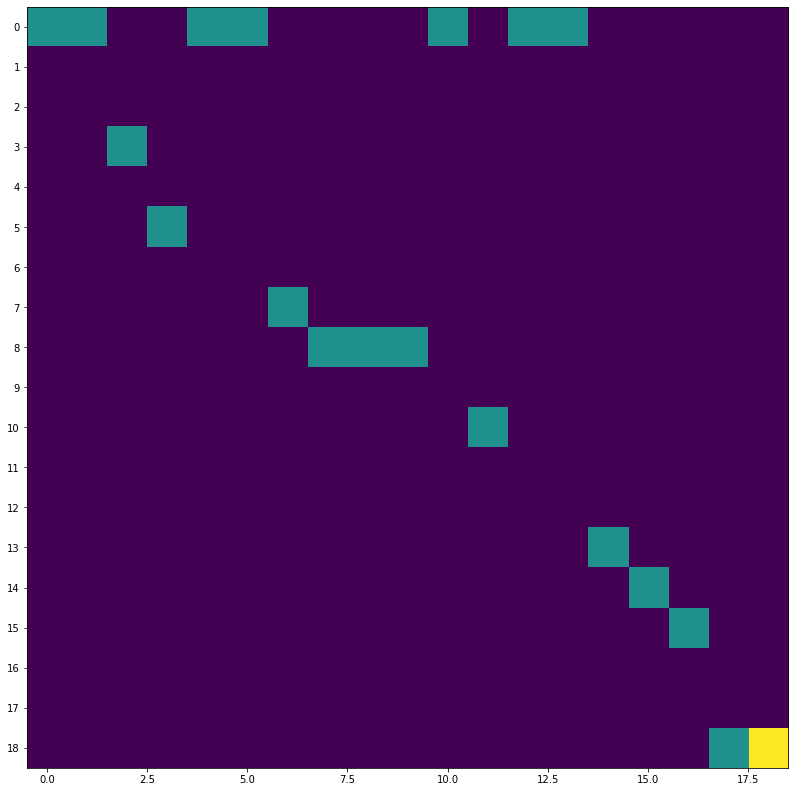

In [451]:
for frame in frames[:]:
    plt.figure(figsize=(22, 14))
    plt.yticks(np.arange(0, 19, 1))
    plt.imshow(frame.T)
    plt.show()

In [461]:
frame

[18, 18]

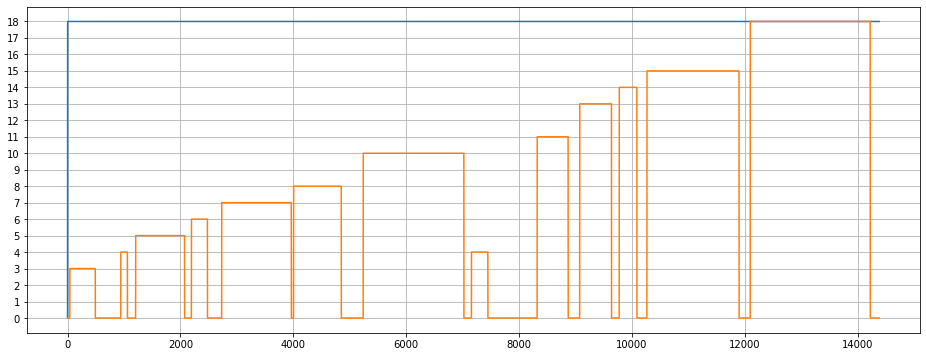

In [494]:
preds = []
targets = []
for frame in frames[:]:
    preds.append(frame[0])
    targets.append(frame[1])

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 19, 1))
plt.plot(preds)
plt.plot(targets)
plt.grid()
plt.show()

In [7]:
torch.cat([torch.from_numpy(np.zeros((32, 2048))), torch.zeros((32, 1))], dim=1).shape

torch.Size([32, 2049])